In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython import display as IPyDisplay
import ipyvolume as ipv
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from tensorflow_graphics.util import safe_ops, asserts, shape
import math
from scipy.spatial.transform import Rotation as R

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13248905214282341789
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6109626976137612818
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 4616038979035292266
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3393323008
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5875842107201082411
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Code for Conversions

- Euler Angles (Z-Y-Z axes rotations) -> Quaternion

- Quaternion -> Euler Angles

- d_q = distance between 2 quaternions

In [3]:
def euler2quaternion(angles):
    """Convert Euler angles to quaternion
    
    Parameters
    ----------
    angles: np.ndarray
        Array of shape (N, 3), where 3 are the 3 anles of rotation around Z-Y-Z axes respectivelly.
        
    Returns
    -------
    quaternion: np.ndarray
        Array of shape (N, 4), where 4 is the 1 real part of quaternion and 3 imaginary parts of quaternion.
    """
    angles = tf.convert_to_tensor(value=angles)

    shape.check_static(tensor=angles, tensor_name="angles", has_dim_equals=(-1, 3))
    
    theta_z1, theta_y, theta_z0 = tf.unstack(angles, axis=-1)

    # create rotation matrix
    c1 = tf.cos(theta_z1)
    c2 = tf.cos(theta_y)
    c3 = tf.cos(theta_z0)

    s1 = tf.sin(theta_z1)
    s2 = tf.sin(theta_y)
    s3 = tf.sin(theta_z0)

    # PROJECTIONS CODE
    r00 = c1*c2*c3-s1*s3
    r01 = -(c1*s3+c2*c3*s1) ##
    r02 = -(-c3*s2)  ##
    r10 = -(-c3*s1-c1*c2*s3) ##
    r11 = c1*c3-c2*s1*s3
    r12 = s2*s3
    r20 = -(c1*s2) ##
    r21 = s1*s2 
    r22 = c2

    w2 = 1/4*(1+ r00 + r11 + r22)
    w2_is_pos = tf.greater(w2, 0)
    
    x2 = -1/2*(r11+r22)
    x2_is_pos = tf.greater(x2, 0)
    
    y2 = 1/2*(1-r22)
    y2_is_pos = tf.greater(y2, 0)
    
    w = tf.compat.v1.where(w2_is_pos, tf.sqrt(w2), tf.zeros_like(w2))
    x = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r21-r12),
                                        tf.compat.v1.where(x2_is_pos, tf.sqrt(x2), tf.zeros_like(x2)))
    y = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r02-r20),
                                        tf.compat.v1.where(x2_is_pos, r01/(2*x), 
                                                                    tf.compat.v1.where(y2_is_pos, tf.sqrt(y2), tf.zeros_like(y2))))
    
    z = tf.compat.v1.where(w2_is_pos, 1/(4*w)*(r10-r01), 
                                        tf.compat.v1.where(x2_is_pos, r02/(2*x), 
                                                                    tf.compat.v1.where(y2_is_pos, r12/(2*y), tf.ones_like(y2))))
    
    return tf.stack((x, y, z, w), axis=-1)

def quaternion2euler(quaternions):
    """ Convert quaternion to Euler angles
    
    Parameters
    ----------
    quaternions: np.ndarray
        The array of shape (N, 4), where 4 is the 1 real part of quaternion and 3 imaginary parts of quaternion.
    
    Returns
    -------
    angles: np.ndarray
        The array of shape (N, 3), where 3 are the 3 anles of rotation around Z-Y-Z axes respectivelly.
    """
    def general_case(r02, r12, r20, r21, r22, eps_addition):
        """Handles the general case."""
        theta_y = tf.acos(r22)
        #sign_sin_theta_y = safe_ops.nonzero_sign(tf.sin(theta_y))
        
        r02 = safe_ops.nonzero_sign(r02) * eps_addition + r02
        r22 = safe_ops.nonzero_sign(r22) * eps_addition + r22
        
        theta_z0 = tf.atan2(r12, r02)
        theta_z1 = tf.atan2(r21, -r20)
        return tf.stack((theta_z1, theta_y, theta_z0), axis=-1)

    def gimbal_lock(r22, r11, r10, eps_addition):
        """Handles Gimbal locks.
        It is gimbal when r22 is -1 or 1"""
        sign_r22 = safe_ops.nonzero_sign(r22)
        r11 = safe_ops.nonzero_sign(r11) * eps_addition + r11
        
        theta_z0 = tf.atan2(sign_r22 * r10, r11)
        
        theta_y = tf.constant(math.pi/2.0, dtype=r20.dtype) - sign_r22 * tf.constant(math.pi/2.0, dtype=r20.dtype)
        theta_z1 = tf.zeros_like(theta_z0)
        angles = tf.stack((theta_z1, theta_y, theta_z0), axis=-1)
        return angles

    with tf.compat.v1.name_scope(None, "euler_from_quaternion", [quaternions]):
        quaternions = tf.convert_to_tensor(value=quaternions)

        shape.check_static(
            tensor=quaternions,
            tensor_name="quaternions",
            has_dim_equals=(-1, 4))

        x, y, z, w = tf.unstack(quaternions, axis=-1)
        tx = safe_ops.safe_shrink(2.0 * x, -2.0, 2.0, True)
        ty = safe_ops.safe_shrink(2.0 * y, -2.0, 2.0, True)
        tz = safe_ops.safe_shrink(2.0 * z, -2.0, 2.0, True)
        twx = tx * w
        twy = ty * w
        twz = tz * w
        txx = tx * x
        txy = ty * x
        txz = tz * x
        tyy = ty * y
        tyz = tz * y
        tzz = tz * z

        # The following is clipped due to numerical instabilities that can take some
        # enties outside the [-1;1] range.
        
        r00 = safe_ops.safe_shrink(1.0 - (tyy + tzz), -1.0, 1.0, True)
        r01 = safe_ops.safe_shrink(txy - twz, -1.0, 1.0, True)
        r02 = safe_ops.safe_shrink(txz + twy, -1.0, 1.0, True)

        r10 = safe_ops.safe_shrink(txy + twz, -1.0, 1.0, True)
        r11 = safe_ops.safe_shrink(1.0 - (txx + tzz), -1.0, 1.0, True)
        r12 = safe_ops.safe_shrink(tyz - twx, -1.0, 1.0, True)

        r20 = safe_ops.safe_shrink(txz - twy, -1.0, 1.0, True)
        r21 = safe_ops.safe_shrink(tyz + twx, -1.0, 1.0, True)
        r22 = safe_ops.safe_shrink(1.0 - (txx + tyy), -1.0, 1.0, True)
        
        eps_addition = asserts.select_eps_for_addition(quaternions.dtype)
        general_solution = general_case(r02, r12, r20, r21, r22, eps_addition)
        gimbal_solution = gimbal_lock(r22, r11, r10, eps_addition)
        
        # The general solution is unstable close to the Gimbal lock, and the gimbal
        # solution is not toooff in these cases.
        # Check if r22 is 1 or -1
        is_gimbal = tf.less(tf.abs(tf.abs(r22) - 1.0), 1.0e-6)
        gimbal_mask = tf.stack((is_gimbal, is_gimbal, is_gimbal), axis=-1)
        
        return tf.compat.v1.where(gimbal_mask, gimbal_solution, general_solution)              
    
def d_q(q1, q2):
    """Distance between 2 quaternions
    
    The quaternion distance takes values between [0, pi]
    
    Parameters
    ----------
    q1: tf.tensor/np.ndarray
        1st quaternion
    q2: tf.tensor/np.ndarray
        2nd quaternion
    
    Returns
    -------
    : distnace between these 2 quaternions
    
    """
    q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float64)
    q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float64)
    
    shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
    shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

    q1 = quaternion.normalize(q1)
    q2 = quaternion.normalize(q2)
    
    dot_product = vector.dot(q1, q2, keepdims=False)
    
    # Ensure dot product is in range [-1. 1].
    eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
    dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

    return 2.0 * tf.acos(tf.abs(dot_product)) 

def distance_difference(angles_predicted, angles_true):
    """Average quaternion distance between true and predicted quaterniosn"""
    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)
    qd = np.mean(d_q(q_predicted, q_true).numpy())
    print(f"Mean `quaternion` distance between true and predicted values: {qd:.3f} rad ({np.degrees(qd):.3f} degrees)")

    return qd

In [4]:
# def euler2quaternion(angles, transposed=True):
#     return R.from_euler('ZYZ', angles).as_quat()


# def quaternion2euler(quaternions, transposed=True):
#     return R.from_quat(quaternions).as_euler("ZYZ")         
    
# def d_q(q1, q2):
#     """Distance between 2 quaternions
    
#     The quaternion distance takes values between [0, pi]
    
#     Parameters
#     ----------
#     q1: tf.tensor/np.ndarray
#         1st quaternion
#     q2: tf.tensor/np.ndarray
#         2nd quaternion
    
#     Returns
#     -------
#     : distnace between these 2 quaternions
    
#     """
#     q1 = tf.cast(tf.convert_to_tensor(value=q1), dtype=tf.float64)
#     q2 = tf.cast(tf.convert_to_tensor(value=q2), dtype=tf.float64)
    
#     shape.check_static(tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
#     shape.check_static(tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

#     q1 = quaternion.normalize(q1)
#     q2 = quaternion.normalize(q2)
    
#     dot_product = vector.dot(q1, q2, keepdims=False)
    
#     # Ensure dot product is in range [-1. 1].
#     eps_dot_prod = 1.8 * asserts.select_eps_for_addition(dot_product.dtype)
#     dot_product = safe_ops.safe_shrink(dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

#     return 2.0 * tf.acos(tf.abs(dot_product)) 

# def distance_difference(angles_predicted, angles_true):
#     """Average quaternion distance between true and predicted quaterniosn"""
#     q_predicted = euler2quaternion(angles_predicted)
#     q_true = euler2quaternion(angles_true)
#     qd = np.mean(d_q(q_predicted, q_true).numpy())
#     print(f"Mean `quaternion` distance between true and predicted values: {qd:.3f} rad ({np.degrees(qd):.3f} degrees)")

#     return qd

# Code for Optimization 

\begin{equation}
\label{eq:phase1}
\operatorname*{min}_{R  \in SO(4), m \in \{-1,1\}} \frac{1}{n} \sum_{i=1} d_q(q_i, R \begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} \hat{q_i})
\end{equation}

- $d_q$ is the distance between two quaternions

\begin{equation}
\label{eq:eq2}
d(q_1,q_2)=2arccos(|<q_1,q_2>|)
\end{equation}

- $q_i \in S^3$ is the quaternion of a true rotation angles

- $\hat{q_i} \in S^3$ is the rotation of the estimatied rotation angles

- $R \in SO(4)$ is $4x4$ orthogonal matrix with determinant 1 that represents a global rotation

- $m \in \{-1,1\}$ represents a global reflection ($m=1$ no reflection, $m=-1$ reflection)

- $\begin{bmatrix}
m & 0\\
0 & I
\end{bmatrix} = \begin{bmatrix}
m & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix}$

In [5]:
def euler6tomarix4d(a_R):
    """ Convert 6D vector containing angles to 4D rotation matrix
    
    a_R: tf.tensor/np.ndarray
        Vector of shape (6,)
    
    Returns
    -------
    R: tf.tensor/np.ndarray
        4x4 Rotation matrix corresponding to these 6 angles of rotations 
    """
    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_old):
    """Update old quaternion with learned rotation
    
    m: np.array
        Array of shape (4,) containing diagonal values for rotation matrix. It is used for flipping the rotation.
        When diagonal value is -1, it is flipped. Otherwise, it is identity.
    a_R: np.array
        Array of shape (6,) containing the rotation angles used to align the old quaternion to the true one.
    q_old: np.ndarray
        Array of shape (N, 4). Quaternions that we will align.
    """
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_new = tf.transpose(R @ I @ tf.transpose(q_old))

    return q_new

def loss_alignment(m, a_R, q_predicted, q_true):
    """Loss for optimization"""
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    """Gradion for optimization"""
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, projection_idx, learning_rate, angles_true, angles_predicted):
    """Optimization"""
    arr = []
    optimizer = Adam(learning_rate=learning_rate)
    
    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    a_R = [tf.Variable(euler)]
    
    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(projection_idx, size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R))
        
        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))
            
            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R, qp)

            arr.append(R.from_quat(update_quaternion(m, a_R, q_predicted)).as_rotvec())
            
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")
            
            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            
            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(.1)
    

        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    return m, a_R, np.mean(losses[-1-steps//10:-1]), arr

# Read data for the optimization

#### Prediction angles from previous phase that we want to align with true angles

In [74]:
def angles_transpose(angles):
    cols = [2, 1, 0]
    idx = np.empty_like(cols)
    idx[cols] = np.arange(len(cols))
    angles[:] = -angles[:, idx]
    return angles

In [6]:
quaternion_predicted = np.load("data/predicted_quaternions2.npy")

---

In [9]:
angles = np.random.uniform(-10, 10, 3)
r1 = R.from_euler('zyz', angles)
r2 = R.from_euler('zyz', -angles[::-1])
np.testing.assert_allclose(r1.as_matrix(), r2.as_matrix().T)
np.testing.assert_allclose(r1.as_quat(), r2.as_quat() * [-1, -1, -1, 1])

In [10]:
angles, r1.as_matrix(), r1.as_quat()

(array([-9.44096449,  8.64122263, -0.33556327]),
 array([[ 0.67413953, -0.31843129,  0.66643635],
        [-0.21796612, -0.9478771 , -0.23242152],
        [ 0.70571004,  0.01142399, -0.70840866]]),
 array([-0.91247264,  0.1469626 , -0.37594179, -0.06680899]))

In [11]:
angles, r1.as_quat()

(array([-9.44096449,  8.64122263, -0.33556327]),
 array([-0.91247264,  0.1469626 , -0.37594179, -0.06680899]))

In [12]:
angles, euler2quaternion(angles).numpy()

(array([-9.44096449,  8.64122263, -0.33556327]),
 array([ 0.91247264, -0.1469626 ,  0.37594179,  0.06680899]))

In [13]:
-angles[::-1], r2.as_matrix().T, r2.as_quat() * [-1, -1, -1, 1]

(array([ 0.33556327, -8.64122263,  9.44096449]),
 array([[ 0.67413953, -0.31843129,  0.66643635],
        [-0.21796612, -0.9478771 , -0.23242152],
        [ 0.70571004,  0.01142399, -0.70840866]]),
 array([-0.91247264,  0.1469626 , -0.37594179, -0.06680899]))

In [18]:
-angles[::-1], euler2quaternion(-angles[::-1]).numpy() * [-1, -1, -1, 1]

(array([ 0.33556327, -8.64122263,  9.44096449]),
 array([ 0.91247264, -0.1469626 ,  0.37594179,  0.06680899]))

In [19]:
print(r1.as_quat())
update_quaternion(m=[1., 1., 1., 1.], 
                  a_R=[np.array([0., 0., 0., 0., 0., 0.])], 
                  q_predicted=np.array([r1.as_quat()])).numpy()

[-0.91247264  0.1469626  -0.37594179 -0.06680899]


array([[-0.91247264,  0.1469626 , -0.37594179, -0.06680899]])

In [20]:
print(r2.as_quat())
update_quaternion(m=[-1., -1., -1., 1.], 
                  a_R=[np.array([0., 0., 0., 0., 0., 0.])], 
                  q_predicted=np.array([r2.as_quat()])).numpy()

[ 0.91247264 -0.1469626   0.37594179 -0.06680899]


array([[-0.91247264,  0.1469626 , -0.37594179, -0.06680899]])

#### True angles

In [21]:
angles_true = np.load("data/angles_true.npy")
#NUM_PROJECTIONS = len(angles_true)

#### Run the Optimization

The `rotation` is our minimizer and we initialize this 6D vector with random values. That is the reason the optimization sometimes converges to 0 loss and sometimes not.

In [77]:
#from cryoem.conversions import euler2quaternion, d_q, quaternion2euler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
#from cryoem.rotation_matrices import euler2matrix, d_r
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(m, steps, batch_size, learning_rate, angles_true, angles_predicted):
    
    arr = []

    optimizer = Adam(learning_rate=learning_rate)

    time_start = time.time()

    report = ""

    losses = np.empty(steps)
    angles_predicted = tf.convert_to_tensor(angles_predicted)

    euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) #np.zeros(6, dtype=np.float64)
    a_R = [tf.Variable(euler)]

    q_predicted = euler2quaternion(angles_predicted)
    q_true = euler2quaternion(angles_true)

    for step in range(1, steps+1):

        # Sample some pairs.
        idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

        # Compute distances between projections
        qt = [q_true[i]      for i in idx]
        qp = [q_predicted[i] for i in idx]

        # Optimize by gradient descent.
        losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
        optimizer.apply_gradients(zip(gradients, a_R))

        update_lr = 300
        if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
            learning_rate *= 0.1

        # Visualize progress periodically
        if step % 10 == 0:
            qu = update_quaternion(m, a_R, q_predicted)

            arr.append(R.from_quat(update_quaternion(m, a_R, q_predicted)).as_rotvec())

            plt.close();
            sns.set(style="white", color_codes=True)
            sns.set(style="whitegrid")

            fig, axs = plt.subplots(1, 3, figsize=(24,7))

            # Distance count subplot (batches)
            qpr = update_quaternion(m, a_R, qp)
            d1 = d_q(qpr, qt)
            axs[0].set_xlim(0, np.pi)
            #axs[0].set_ylim(0, batch_size)
            axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
            s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

            # Optimization loss subplot
            axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
            axs[1].set_xlabel('time [s]')
            axs[1].set_ylabel('loss');
            axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

            # Distance count subplot (full)
            q_predicted_rot = update_quaternion(m, a_R, q_predicted)
            d2 = d_q(q_predicted_rot, q_true)
            axs[2].set_xlim(0, np.pi)
            # axs[2].set_ylim(0, len(angles_true))
            axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
            s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
            max_count = int(max([h.get_height() for h in s.patches]))
            axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)


            IPyDisplay.clear_output(wait=True)
            IPyDisplay.display(plt.gcf())
            plt.close();
            time.sleep(1.0)


        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time.time() - time_start
            report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

        if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
            break;

    print(report)
    return m, a_R, losses, np.array(arr)

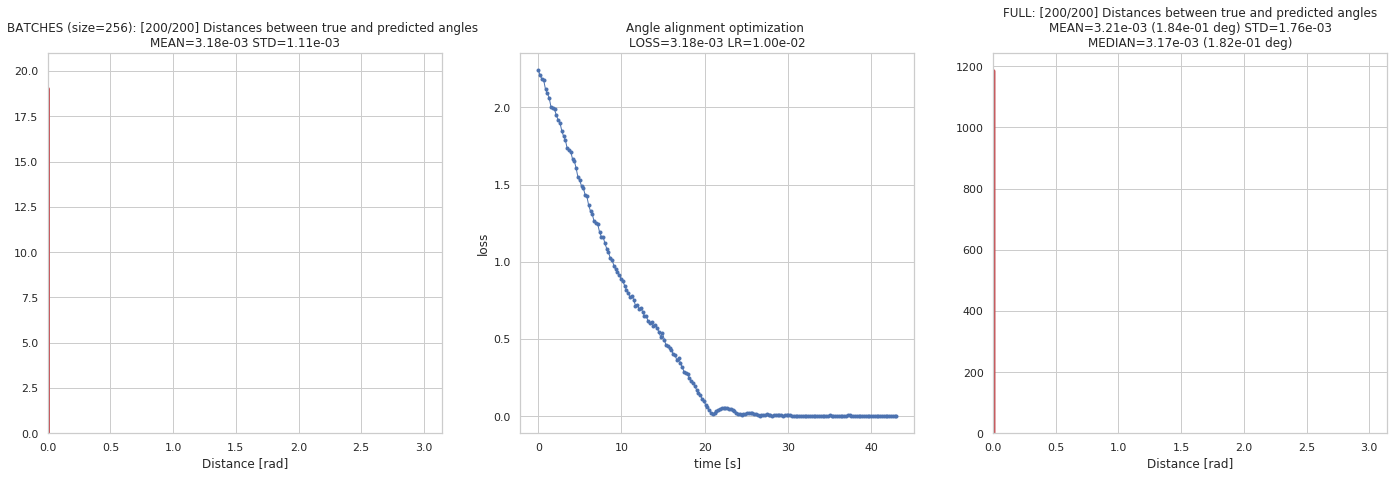

step 20/200 (4s): loss = 1.97e+00
step 40/200 (9s): loss = 1.35e+00
step 60/200 (13s): loss = 8.34e-01
step 80/200 (18s): loss = 5.07e-01
step 100/200 (22s): loss = 1.55e-01
step 120/200 (27s): loss = 3.28e-02
step 140/200 (31s): loss = 7.81e-03
step 160/200 (36s): loss = 3.23e-03
step 180/200 (40s): loss = 3.48e-03
step 200/200 (45s): loss = 3.22e-03



In [26]:
m, rotation, loss, arr  = training_angle_alignment(m=[1.0, 1.0, 1.0, 1.0],
                                                 steps=200, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted)

In [28]:
m, rotation[0].numpy(), loss[-1]

([1.0, 1.0, 1.0, 1.0],
 array([5.10546051, 3.69363913, 2.79047945, 3.06085126, 2.5610858 ,
        3.82092027]),
 0.0026100085426999176)

In [30]:
arr2 = R.from_euler('ZYZ', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arr[:, :,0], arr[:, :,1], arr[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

In [81]:
angles_predicted_T = angles_transpose(angles_predicted)
angles_predicted_T

array([[ 2.97444801, -1.69700539,  0.27767634],
       [-1.6639683 , -1.04998219, -0.59764091],
       [-1.20397157, -1.4117166 , -0.2497224 ],
       ...,
       [ 0.46647467, -1.29031964, -1.25690316],
       [ 1.60739494, -0.42865127, -0.1440733 ],
       [-0.09104401, -1.32784058,  0.72799575]])

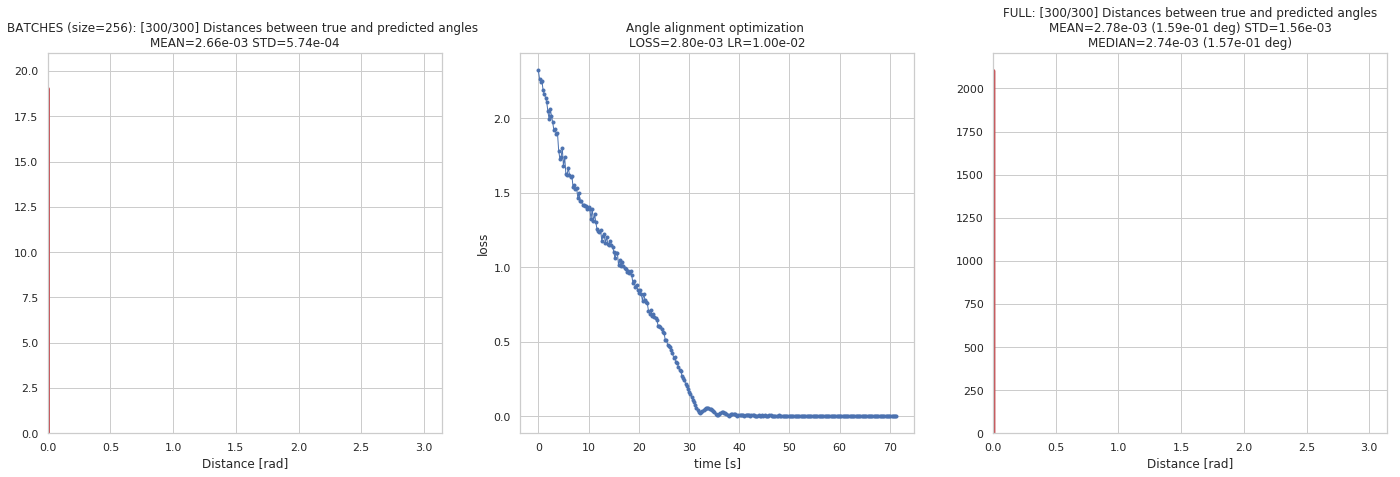

step 30/300 (7s): loss = 1.92e+00
step 60/300 (14s): loss = 1.35e+00
step 90/300 (22s): loss = 9.73e-01
step 120/300 (29s): loss = 5.50e-01
step 150/300 (37s): loss = 9.50e-02
step 180/300 (44s): loss = 1.09e-02
step 210/300 (51s): loss = 4.03e-03
step 240/300 (58s): loss = 3.37e-03
step 270/300 (66s): loss = 3.07e-03
step 300/300 (73s): loss = 2.84e-03



In [91]:
m, rotation, loss, arr  = training_angle_alignment(m=[-1., 1., 1., 1.],
                                                 steps=300, 
                                                 batch_size=256, 
                                                 learning_rate=0.01, 
                                                 angles_true=angles_true, 
                                                 angles_predicted=angles_predicted_T)

In [92]:
m, rotation[0].numpy(), loss[-1]

([-1.0, 1.0, 1.0, 1.0],
 array([ 1.96364989,  5.73101437,  2.79074904, -0.08022972, -0.58154017,
        -0.67984883]),
 0.0029265572355517662)

In [93]:
arr2 = R.from_euler('ZYZ', angles_true).as_rotvec()

ipv.figure()
s = ipv.scatter(arr[:, :,0], arr[:, :,1], arr[:, :,2], marker="sphere", color="blue", size=1)
ipv.scatter(arr2[:,0], arr2[:,1], arr2[:,2], marker="sphere", color="red", size=1)
ipv.animation_control(s, interval=200)
ipv.show()

#### Plot the Topology

Consider the solid ball in $\mathbb {R} ^{3}$ of radius π (that is, all points of $\mathbb {R} ^{3}$ of distance π or less from the origin). Given the above, for every point in this ball there is a rotation, with axis through the point and the origin, and rotation angle equal to the distance of the point from the origin. The identity rotation corresponds to the point at the center of the ball. Rotation through angles between 0 and −π correspond to the point on the same axis and distance from the origin but on the opposite side of the origin. The one remaining issue is that the two rotations through π and through −π are the same. So we identify (or "glue together") antipodal points on the surface of the ball. After this identification, we arrive at a topological space homeomorphic to the rotation group. Reference [wiki](https://en.wikipedia.org/wiki/3D_rotation_group)